Nama: Maylani Kusuma Wardhani  
Nim: 202210370311123  
Kelas: Pemodelan dan Simulasi Data C

In [ ]:
!pip install simpy

Customer 1 (Tellers: 1, VIP: True) arrives at 0.13 min.
Customer 1 (Tellers: 1) starts service after waiting 0.00 min.
Customer 1 (Tellers: 1) finished service at 0.16 min.
Customer 2 (Tellers: 1, VIP: False) arrives at 0.17 min.
Customer 2 (Tellers: 1) starts service after waiting 0.00 min.
Customer 3 (Tellers: 1, VIP: True) arrives at 0.31 min.
Customer 4 (Tellers: 1, VIP: True) arrives at 0.38 min.
Customer 5 (Tellers: 1, VIP: False) arrives at 0.41 min.
Customer 6 (Tellers: 1, VIP: True) arrives at 0.41 min.
Customer 2 (Tellers: 1) finished service at 0.49 min.
Customer 3 (Tellers: 1) starts service after waiting 0.18 min.
Customer 7 (Tellers: 1, VIP: False) arrives at 0.54 min.
Customer 3 (Tellers: 1) finished service at 0.60 min.
Customer 4 (Tellers: 1) starts service after waiting 0.22 min.
Customer 8 (Tellers: 1, VIP: True) arrives at 0.65 min.
Customer 4 (Tellers: 1) finished service at 0.84 min.
Customer 6 (Tellers: 1) starts service after waiting 0.42 min.
Customer 9 (Teller

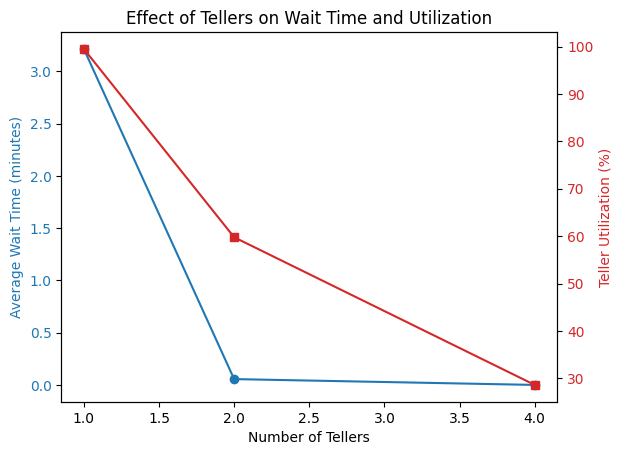

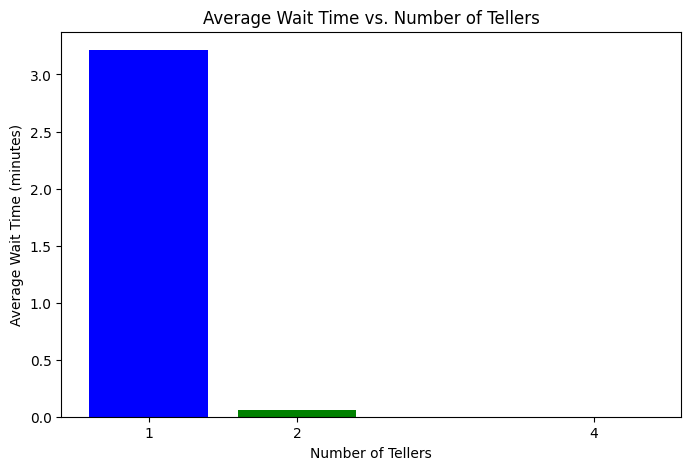

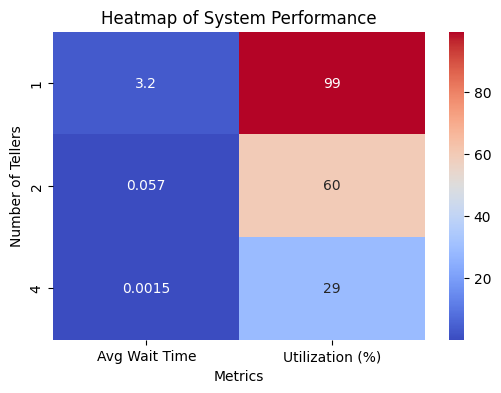

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import simpy

# Simulation Parameters
RANDOM_SEED = 42
ARRIVAL_RATE_PEAK = 8  # Simulated peak hours (customers per minute)
SERVICE_RATE = 7       # Average service rate (customers served per minute)
SIM_TIME = 30         # Total simulation time in minutes

# Store results
results = {}

class BankQueueSimulation:
    def __init__(self, env, num_tellers, service_rate):
        self.env = env
        self.teller = simpy.PriorityResource(env, num_tellers)
        self.service_rate = service_rate
        self.utilization = []
        self.num_tellers = num_tellers

    def serve_customer(self, customer_id, num_tellers):
        service_time = random.expovariate(self.service_rate)
        yield self.env.timeout(service_time)
        self.utilization.append(service_time)
        print(f"Customer {customer_id} (Tellers: {num_tellers}) finished service at {self.env.now:.2f} min.")

def customer_process(env, customer_id, bank, num_tellers, is_vip=False):
    arrival_time = env.now
    priority = 0 if is_vip else 1  # VIP customers have higher priority
    print(f"Customer {customer_id} (Tellers: {num_tellers}, VIP: {is_vip}) arrives at {arrival_time:.2f} min.")

    with bank.teller.request(priority=priority) as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)
        print(f"Customer {customer_id} (Tellers: {num_tellers}) starts service after waiting {wait_time:.2f} min.")
        yield env.process(bank.serve_customer(customer_id, num_tellers))

def customer_arrivals(env, bank, arrival_rate, num_tellers):
    customer_id = 0
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        customer_id += 1
        is_vip = random.random() < 0.2  # 20% chance a customer is VIP
        env.process(customer_process(env, customer_id, bank, num_tellers, is_vip))

def run_simulation(num_tellers):
    global wait_times
    wait_times = []
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    bank = BankQueueSimulation(env, num_tellers, SERVICE_RATE)
    env.process(customer_arrivals(env, bank, ARRIVAL_RATE_PEAK, num_tellers))
    env.run(until=SIM_TIME)
    results[num_tellers] = {
        'average_wait_time': np.mean(wait_times),
        'utilization': sum(bank.utilization) / (SIM_TIME * num_tellers),
        'wait_times': wait_times.copy()
    }

# Run simulations with different numbers of tellers
for tellers in [1, 2, 4]:
    run_simulation(tellers)

# Performance Analysis
for tellers, data in results.items():
    print(f"\n=== Simulation Summary (Tellers: {tellers}) ===")
    print(f"Average Wait Time: {data['average_wait_time']:.2f} minutes")
    print(f"Teller Utilization: {data['utilization']:.2%}")

# Visualization
teller_counts = list(results.keys())
wait_times = [results[t]['average_wait_time'] for t in teller_counts]
utilization = [results[t]['utilization'] for t in teller_counts]

fig, ax1 = plt.subplots()
ax1.set_xlabel("Number of Tellers")
ax1.set_ylabel("Average Wait Time (minutes)", color='tab:blue')
ax1.plot(teller_counts, wait_times, marker='o', color='tab:blue', label="Avg Wait Time")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Teller Utilization (%)", color='tab:red')
ax2.plot(teller_counts, [u * 100 for u in utilization], marker='s', color='tab:red', label="Utilization")
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Effect of Tellers on Wait Time and Utilization")
plt.show()

# Bar Chart Visualization
plt.figure(figsize=(8, 5))
plt.bar(teller_counts, wait_times, color=['blue', 'green', 'red'])
plt.xlabel("Number of Tellers")
plt.ylabel("Average Wait Time (minutes)")
plt.title("Average Wait Time vs. Number of Tellers")
plt.xticks(teller_counts)
plt.show()

# Heatmap Visualization
data_matrix = np.array([[results[t]['average_wait_time'], results[t]['utilization'] * 100] for t in teller_counts])
plt.figure(figsize=(6, 4))
sns.heatmap(data_matrix, annot=True, cmap="coolwarm", xticklabels=["Avg Wait Time", "Utilization (%)"], yticklabels=teller_counts)
plt.xlabel("Metrics")
plt.ylabel("Number of Tellers")
plt.title("Heatmap of System Performance")
plt.show()
